In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import ConfusionMatrix


dataset_full = torchvision.datasets.FashionMNIST('data', train = True, download = True, transform = transforms.ToTensor())

# dataset_full.classes
idx_tshirt_trouser = [0, 1]
idx_pullover_dress = [2, 3]
idx_tshirt_trouser_pullover_dress = [0,1,2, 3]

dataset_tshirt_trouser = [data for data in dataset_full if data[1] in idx_tshirt_trouser] # 01
dataset_pullover_dress = [data for data in dataset_full if data[1] in idx_pullover_dress] # 23
dataset_tshirt_trouser_pullover_dress = [data for data in dataset_full if data[1] in idx_tshirt_trouser_pullover_dress]


train_dataset_all, test_dataset_all = torch.utils.data.dataset.random_split(dataset_full, [50000, 10000])
train_dataset_01, test_dataset_01 = torch.utils.data.dataset.random_split(dataset_tshirt_trouser, [10000, 2000])
train_dataset_23, test_dataset_23 = torch.utils.data.dataset.random_split(dataset_pullover_dress, [10000, 2000])
train_dataset_0123, test_dataset_0123 = torch.utils.data.dataset.random_split(dataset_tshirt_trouser_pullover_dress, [20000, 4000])


from torch.utils.data import Dataset, DataLoader

batch_size = 8

train_loader_all = DataLoader(train_dataset_all, batch_size=batch_size)
test_loader_all = DataLoader(test_dataset_all, batch_size=batch_size)

train_loader_01 = DataLoader(train_dataset_01, batch_size=batch_size)
test_loader_01 = DataLoader(test_dataset_01, batch_size=batch_size)

train_loader_23 = DataLoader(train_dataset_23, batch_size=batch_size)
test_loader_23 = DataLoader(test_dataset_23, batch_size=batch_size)

train_loader_0123 = DataLoader(train_dataset_0123, batch_size=batch_size)
test_loader_0123 = DataLoader(test_dataset_0123, batch_size=batch_size)



In [2]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(in_features=64 * 6 * 6, out_features=600)
        # self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=4)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        # out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [3]:
import torch

L01 = []
L23 = []

for i in range(50):
    # Charger le modèle
    model = FashionCNN()
    model.load_state_dict(torch.load(fr'v2/model_01_0123_2layers_ex_{i}.pth')['model_state_dict'])
    model.eval()
    L01.append(model)
    model = FashionCNN()
    model.load_state_dict(torch.load(fr'v2/model_23_0123_2layers_ex_{i}.pth')['model_state_dict'])
    model.eval()
    L23.append(model)

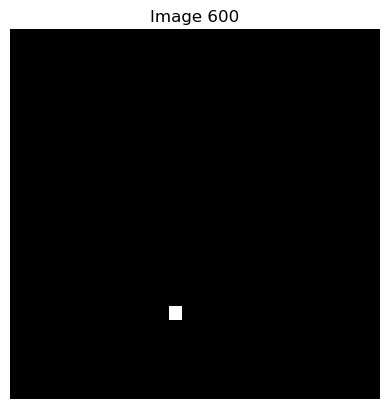

In [4]:
# Create an array to store all images
images = np.zeros((784, 28, 28))

for i in range(784):
    image = np.zeros((28, 28))
    row = i // 28
    col = i % 28
    image[row, col] = 1
    images[i] = image

idx = 600
plt.imshow(images[idx], cmap="gray")
plt.axis("off")
plt.title(f"Image {idx}")
plt.show()

## Créations d'images dataset mix

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
from tabulate import tabulate
from torch.utils.data import DataLoader, Dataset
from torchmetrics.classification import ConfusionMatrix

import os
import struct
import cv2

In [6]:
def create_hybrid(image1, image2):

    image_width = image1.shape[1]
    image_height = image1.shape[0]
    kernel_size = (int(image_height/5), int(image_width/5))

    image2 = cv2.resize(image2, (image_width, image_height))

    # Apply a low-pass filter (Gaussian blur) to image 1
    # Apply a high-pass filter (subtract blurred image from original) to image 2
    image1_blur = cv2.GaussianBlur(image1, kernel_size, 0)
    image1_highpass = image1 - image1_blur

    # Apply a low-pass filter (Gaussian blur) to image 2
    # Apply a high-pass filter (subtract blurred image from original) to image 2
    image2_blur = cv2.GaussianBlur(image2, kernel_size, 0)
    image2_highpass = image2 - image2_blur

    # Combine the low-frequency component of image 1 with the high-frequency component of image 2
    hybrid_image1 = image1_blur + image2_highpass

    # Combine the low-frequency component of image 2 with the high-frequency component of image 1
    hybrid_image2 = image2_blur + image1_highpass

    # Divid all images pixels by a value and add them together
    image1 = image1/3
    image2 = image2/3
    hybrid_image3 = image1 + image2

    return hybrid_image1, hybrid_image2, hybrid_image3

In [7]:
# Path to FashionMNIST dataset

dataset_full = torchvision.datasets.FashionMNIST('data', train = True, download = True, transform = transforms.ToTensor())


# dataset_full.classes
idx_0 = [0]
idx_1 = [1]
idx_2 = [2]
idx_3 = [3]
idx_pullover_dress = [2, 3]
idx_tshirt_trouser_pullover_dress = [0,1,2, 3]

dataset_0 = [data for data in dataset_full if data[1] in idx_0] 
dataset_1 = [data for data in dataset_full if data[1] in idx_1]
dataset_2 = [data for data in dataset_full if data[1] in idx_2]
dataset_3 = [data for data in dataset_full if data[1] in idx_3]

In [8]:
datasets = {0: dataset_0, 1: dataset_1, 2:dataset_2, 3:dataset_3}
images = []
for i in range(1):
    for j in range(2,3):
        for p in range(600):
            images.append(create_hybrid(datasets[i][p][0].numpy().reshape(28, 28),datasets[j][p][0].numpy().reshape(28, 28))[0])

# Test part

## Test with a neural network

#### Creation of the data

In [12]:
import torch
import numpy as np
L01 = []
L23 = []

for i in range(50):
    # Charger le modèle
    model = FashionCNN()
    model.load_state_dict(torch.load(fr'v2/model_01_0123_2layers_ex_{i}.pth')['model_state_dict'])
    model.eval()
    L01.append(model)
    model = FashionCNN()
    model.load_state_dict(torch.load(fr'v2/model_23_0123_2layers_ex_{i}.pth')['model_state_dict'])
    model.eval()
    L23.append(model)

In [13]:
len(images)

600

In [14]:
data = np.zeros([100,601])
data_test = np.zeros([20,601])
for i in range(50):
    model1 = FashionCNN()
    model1.load_state_dict(torch.load(fr'v2/model_01_0123_2layers_ex_{i}.pth')['model_state_dict'])
    model1.eval()
    model2 = FashionCNN()
    model2.load_state_dict(torch.load(fr'v2/model_23_0123_2layers_ex_{i}.pth')['model_state_dict'])
    model2.eval()
    for j in range(600):
        data[i,j] = model1(torch.tensor(images[j], dtype = torch.float).unsqueeze(0).unsqueeze(0)).argmax(1).item()
        data[i,600] = 0
        data[i+40,j] = model2(torch.tensor(images[j], dtype = torch.float).unsqueeze(0).unsqueeze(0)).argmax(1).item()
        data[i+40,600] = 1
        
        
for i in range(50,60):
    model1 = FashionCNN()
    model1.load_state_dict(torch.load(fr'v2/model_01_0123_2layers_ex_{i}.pth')['model_state_dict'])
    model1.eval()
    model2 = FashionCNN()
    model2.load_state_dict(torch.load(fr'v2/model_23_0123_2layers_ex_{i}.pth')['model_state_dict'])
    model2.eval()
    for j in range(600):
        data_test[i-50,j] = model1(torch.tensor(images[j], dtype = torch.float).unsqueeze(0).unsqueeze(0)).argmax(1).item()
        data_test[i-50,600] = 0
        data_test[i+10-50,j] = model2(torch.tensor(images[j], dtype = torch.float).unsqueeze(0).unsqueeze(0)).argmax(1).item()
        data_test[i+10-50,600] = 1

In [15]:
data.shape

(100, 601)

In [16]:
data_test.shape

(20, 601)

NN model

In [17]:
class Deep(nn.Module):
    def __init__(self):
        super(Deep, self).__init__()
        self.fc1 = nn.Linear(600, 1000)
        self.fc2 = nn.Linear(1000, 300)
        self.fc3 = nn.Linear(300, 2)

    def forward(self, x):
        x = x.view(-1, 600)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)
    
    
# Define model
model_args = {}
# random seed
model_args['seed'] = 123
# we will use batch size of 128 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 10
# learning rate is how fast it will descend
model_args['lr'] = .05
# SGD momentum (default: .5) momentum is a moving average of gradients (it helps to keep direction)
model_args['momentum'] = .5
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 30
# logging frequency
model_args['log_interval'] = 1

In [18]:
class PixelDataset(Dataset):
    def __init__(self, signals, annotations):
        self.signals = signals
        self.annotations = annotations
        
    def __len__(self):
        return len(self.signals)
    
    def __getitem__(self, idx):
        signal = self.signals[idx]
        annotation = self.annotations[idx]
        return signal, annotation

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Split data into train and test sets
X_train, y_train = data[:,:-1], data[:,-1]
X_test, y_test = data_test[:,:-1], data[:,-1]
print(X_train.shape, y_train.shape)

# Convert data to PyTorch tensors and move to GPU
X_train = torch.Tensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Create DataLoader
train_dataset = PixelDataset(X_train, y_train)
test_dataset = PixelDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=model_args['batch_size'], shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=model_args['batch_size'], shuffle=False)


(100, 600) (100,)


In [20]:
model = Deep().to(device)

# Définir l'optimiseur et la fonction de perte
optimizer = optim.SGD(model.parameters(), lr=model_args['lr'], momentum=model_args['momentum'])
class_weights = torch.tensor([1, 1], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Fonction d'entraînement
def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % model_args['log_interval'] == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Fonction de test
def test(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            pred = pred.squeeze()
            # Réinitialisation des variables
           

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print('\nTest set: \nAverage loss: {:.4f}, \nAccuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))

# Training
for epoch in range(1, model_args['epochs'] + 1):
    train(model, train_loader, optimizer, criterion, epoch)
    test(model, test_loader)

Train Epoch: 1 [0/100 (0%)]	Loss: 0.701818
Train Epoch: 1 [10/100 (10%)]	Loss: 0.709077
Train Epoch: 1 [20/100 (20%)]	Loss: 0.581174
Train Epoch: 1 [30/100 (30%)]	Loss: 0.550521
Train Epoch: 1 [40/100 (40%)]	Loss: 0.399774
Train Epoch: 1 [50/100 (50%)]	Loss: 0.832717
Train Epoch: 1 [60/100 (60%)]	Loss: 0.338381
Train Epoch: 1 [70/100 (70%)]	Loss: 0.709760
Train Epoch: 1 [80/100 (80%)]	Loss: 0.495027
Train Epoch: 1 [90/100 (90%)]	Loss: 0.560351

Test set: 
Average loss: 0.0628, 
Accuracy: 14/20 (70.00%)

Train Epoch: 2 [0/100 (0%)]	Loss: 0.186982
Train Epoch: 2 [10/100 (10%)]	Loss: 0.135142
Train Epoch: 2 [20/100 (20%)]	Loss: 0.650489
Train Epoch: 2 [30/100 (30%)]	Loss: 0.154013
Train Epoch: 2 [40/100 (40%)]	Loss: 0.240951
Train Epoch: 2 [50/100 (50%)]	Loss: 0.224706
Train Epoch: 2 [60/100 (60%)]	Loss: 0.266659
Train Epoch: 2 [70/100 (70%)]	Loss: 0.301374
Train Epoch: 2 [80/100 (80%)]	Loss: 0.433912
Train Epoch: 2 [90/100 (90%)]	Loss: 1.059508

Test set: 
Average loss: 0.1072, 
Accuracy

Train Epoch: 20 [60/100 (60%)]	Loss: 0.011800
Train Epoch: 20 [70/100 (70%)]	Loss: 0.000060
Train Epoch: 20 [80/100 (80%)]	Loss: 0.011638
Train Epoch: 20 [90/100 (90%)]	Loss: 0.002844

Test set: 
Average loss: 0.2937, 
Accuracy: 10/20 (50.00%)

Train Epoch: 21 [0/100 (0%)]	Loss: 0.011408
Train Epoch: 21 [10/100 (10%)]	Loss: 0.000539
Train Epoch: 21 [20/100 (20%)]	Loss: 0.011557
Train Epoch: 21 [30/100 (30%)]	Loss: 0.000478
Train Epoch: 21 [40/100 (40%)]	Loss: 0.022474
Train Epoch: 21 [50/100 (50%)]	Loss: 0.011297
Train Epoch: 21 [60/100 (60%)]	Loss: 0.013167
Train Epoch: 21 [70/100 (70%)]	Loss: 0.011120
Train Epoch: 21 [80/100 (80%)]	Loss: 0.000361
Train Epoch: 21 [90/100 (90%)]	Loss: 0.032570

Test set: 
Average loss: 0.2990, 
Accuracy: 10/20 (50.00%)

Train Epoch: 22 [0/100 (0%)]	Loss: 0.032351
Train Epoch: 22 [10/100 (10%)]	Loss: 0.012618
Train Epoch: 22 [20/100 (20%)]	Loss: 0.010520
Train Epoch: 22 [30/100 (30%)]	Loss: 0.000148
Train Epoch: 22 [40/100 (40%)]	Loss: 0.010648
Train Ep